# Data Analysis from CSV writer in OpenVibe


In [1]:
# Some standard pythonic imports
import os
from collections import OrderedDict
import pandas as pd
import numpy as np

#%matplotlib qt


#import warnings
#warnings.filterwarnings('ignore')

# MNE function
import mne

# EEG-Notebooks functions
#from eegnb.analysis.utils import load_data,plot_conditions
#from eegnb.datasets import fetch_dataset

# Get Data

In [13]:
csv_path = "../data/tina_new_paradigm/tina.csv"
eeg_df = df = pd.read_csv(csv_path)
print(eeg_df.head(20))

    Time:128Hz  Epoch          AF3           F7           F3          FC5  \
0     0.000000      0  4058.589844  4103.589844  4072.051270  4058.205078   
1     0.007812      0  4065.000000  4108.461426  4080.000000  4061.666748   
2     0.015625      0  4068.589844  4111.538574  4088.076904  4058.205078   
3     0.023438      0  4067.051270  4111.538574  4092.179443  4050.897461   
4     0.031250      0  4061.794922  4108.717773  4091.025635  4045.000000   
5     0.039062      0  4057.564209  4106.410156  4087.948730  4045.897461   
6     0.046875      0  4059.743652  4109.102539  4088.718018  4055.769287   
7     0.054688      0  4068.974365  4118.461426  4096.666504  4071.281982   
8     0.062500      0  4079.871826  4130.256348  4108.717773  4084.102539   
9     0.070312      0  4083.846191  4137.179688  4116.794922  4085.897461   
10    0.078125      0  4076.794922  4134.487305  4114.871582  4075.512939   
11    0.085938      0  4062.564209  4123.589844  4103.846191  4059.871826   

Creating RawArray with float64 data, n_channels=14, n_times=221248
    Range : 0 ... 221247 =      0.000 ...  1728.492 secs
Ready.


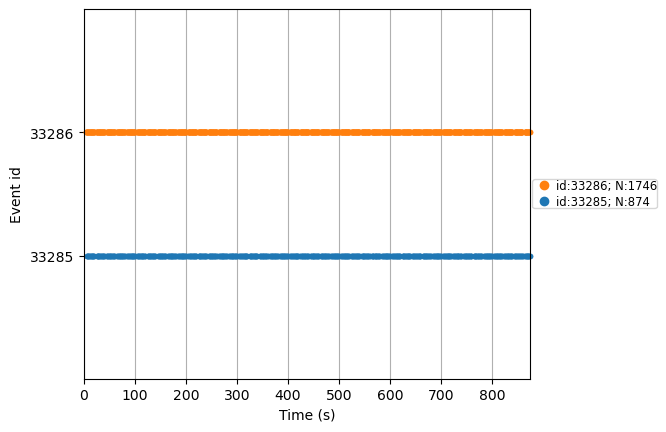

Not setting metadata
2620 matching events found
Setting baseline interval to [-0.203125, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2620 events and 129 original time points ...
0 bad epochs dropped
Using matplotlib as 2D backend.


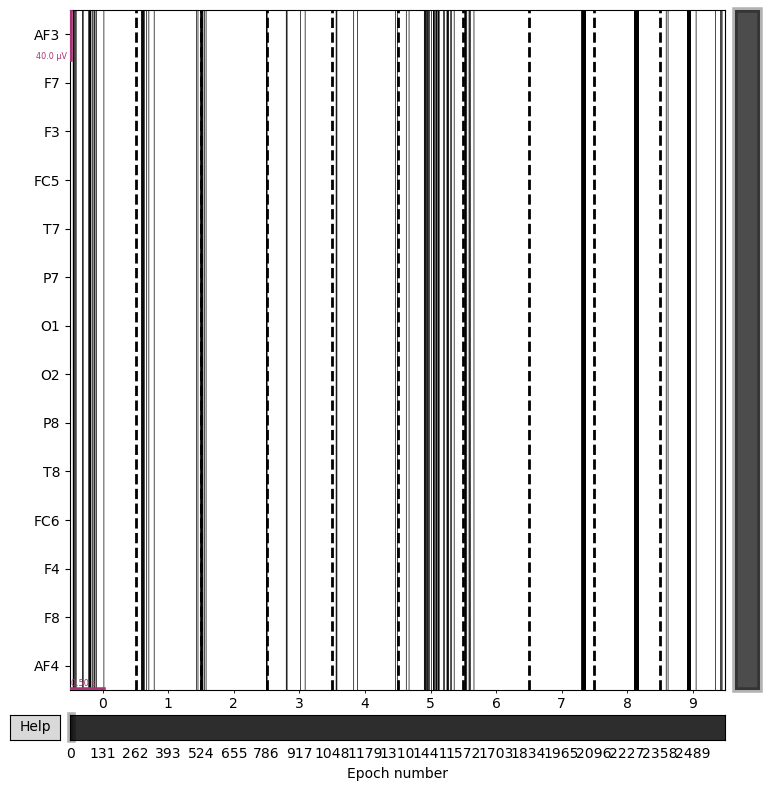

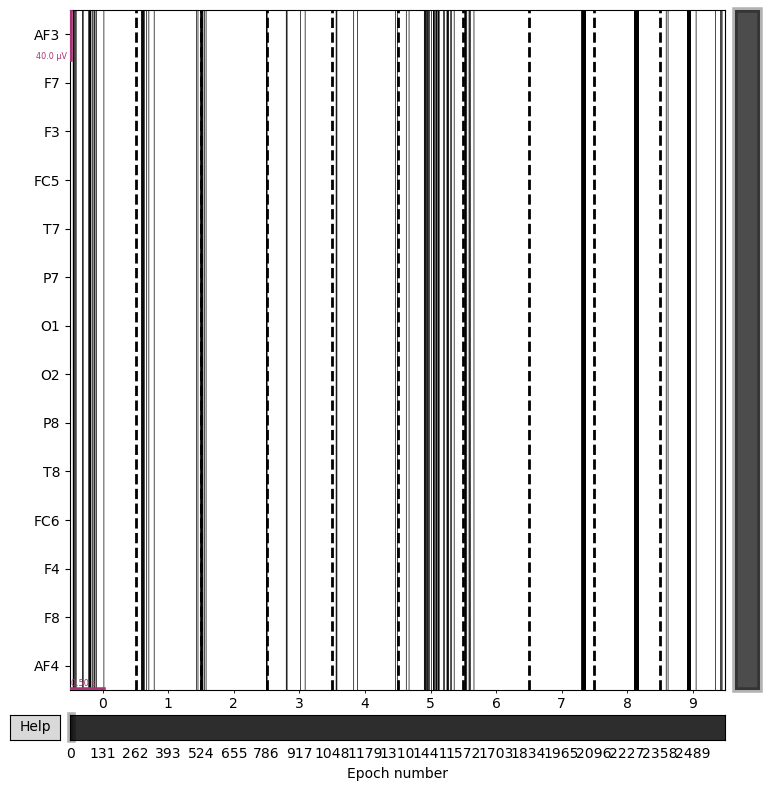

In [3]:
# Sampling rate
sfreq = 128

# Extract EEG channel names
eeg_channels = ['AF3','F7','F3','FC5','T7','P7','O1','O2','P8','T8','FC6','F4','F8','AF4']

# Extract EEG data
eeg_data = df[eeg_channels].to_numpy().T  # MNE expects shape (n_channels, n_samples)

# Create MNE info and Raw object
info = mne.create_info(ch_names=eeg_channels, sfreq=sfreq, ch_types='eeg')
raw = mne.io.RawArray(eeg_data, info)

# Add marker channel as annotations
event_ids = df['Event Id'].fillna(0).astype(int).to_numpy()
times = np.arange(len(event_ids)) / sfreq

# Collect non-zero events (ignore 0 = no event)
events = []
for i, ev in enumerate(event_ids):
    if ev != 0:
        events.append([i, 0, ev])
events = np.array(events)

# Optional: convert event IDs to named labels
event_dict = {
    "target": 33285,
    "nontarget": 33286
}

# Visual inspection
mne.viz.plot_events(events, sfreq=sfreq)

# Epoching (example for P300)
epochs = mne.Epochs(raw, events, event_id=event_dict,
                    tmin=-0.2, tmax=0.8, baseline=(None, 0), preload=True)

epochs.plot(n_epochs=10, n_channels=14)


In [9]:
# check correlation
corr = np.corrcoef(raw.get_data())
np.round(corr, 2)  # Rounded for readability

array([[1.  , 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.98, 0.98, 0.98, 0.98,
        0.97, 0.98, 0.98],
       [0.97, 1.  , 0.97, 0.97, 0.97, 0.97, 0.97, 0.98, 0.98, 0.98, 0.98,
        0.97, 0.98, 0.98],
       [0.97, 0.97, 1.  , 0.97, 0.97, 0.97, 0.97, 0.98, 0.98, 0.98, 0.98,
        0.97, 0.98, 0.98],
       [0.97, 0.97, 0.97, 1.  , 0.97, 0.97, 0.97, 0.98, 0.98, 0.98, 0.98,
        0.97, 0.98, 0.98],
       [0.97, 0.97, 0.97, 0.97, 1.  , 0.97, 0.97, 0.98, 0.98, 0.98, 0.98,
        0.97, 0.98, 0.98],
       [0.97, 0.97, 0.97, 0.97, 0.97, 1.  , 0.97, 0.98, 0.98, 0.98, 0.98,
        0.96, 0.98, 0.98],
       [0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 1.  , 0.98, 0.98, 0.98, 0.98,
        0.96, 0.98, 0.98],
       [0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 1.  , 0.99, 0.99, 0.99,
        0.98, 0.99, 0.99],
       [0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.99, 1.  , 0.99, 0.99,
        0.98, 0.99, 0.99],
       [0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.99, 0.99, 1.  , 0.99,
        0.98, 0.9

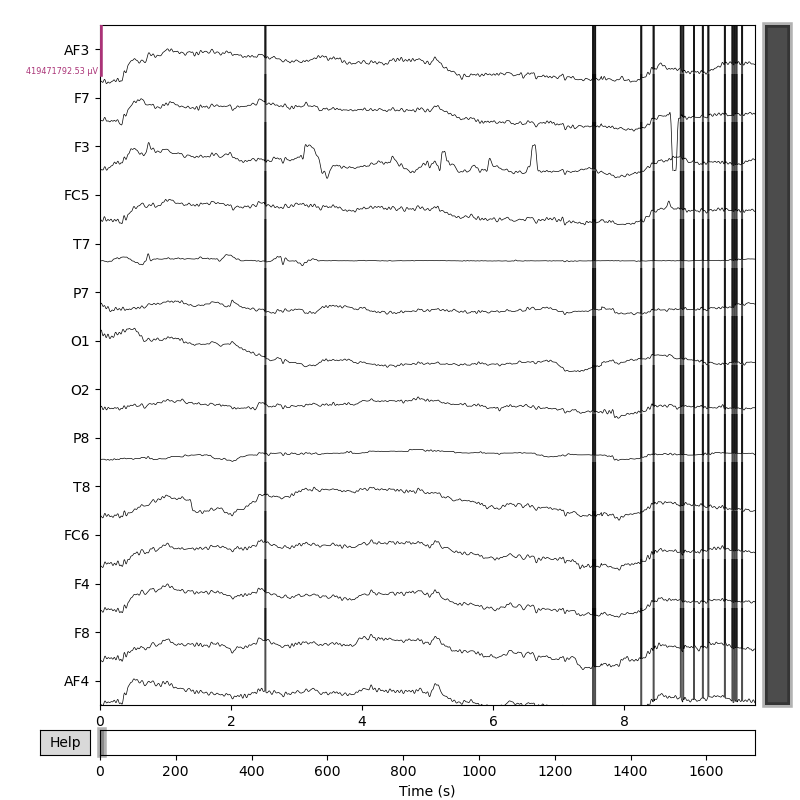

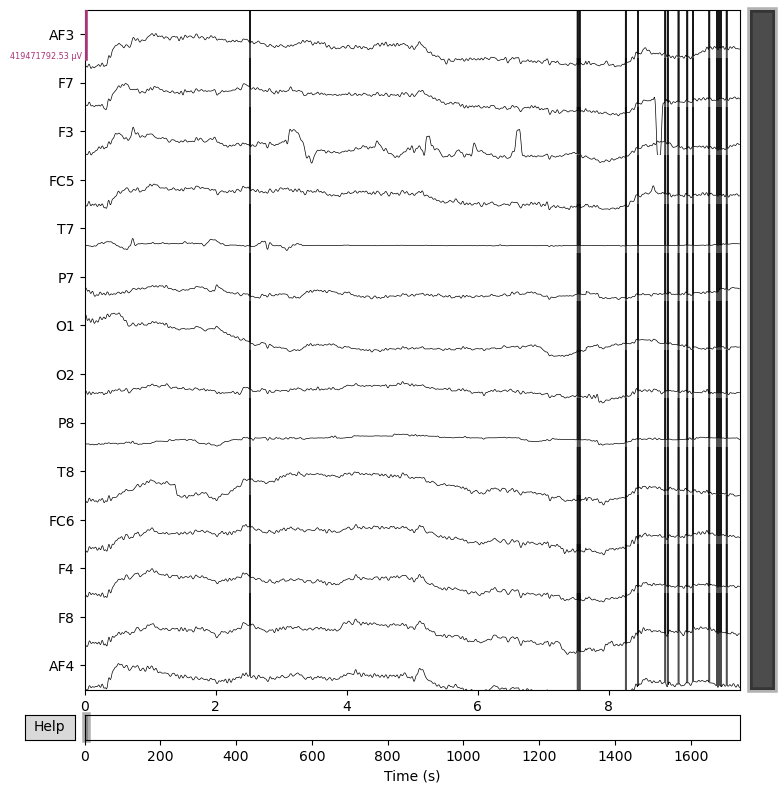

In [14]:
%matplotlib widget

#df[eeg_channels].iloc[:500].plot(figsize=(12, 4), title="Raw EEG Snapshot")

raw.plot(n_channels=14, scalings='auto', duration=10)


In [7]:

evoked_target = epochs['target'].average()
print(evoked_target)
#evoked_target.plot(spatial_colors=True, proj=True)


<Evoked | 'target' (average, N=874), -0.20312 – 0.79688 s, baseline -0.203125 – 0 s, 14 ch, ~32 KiB>


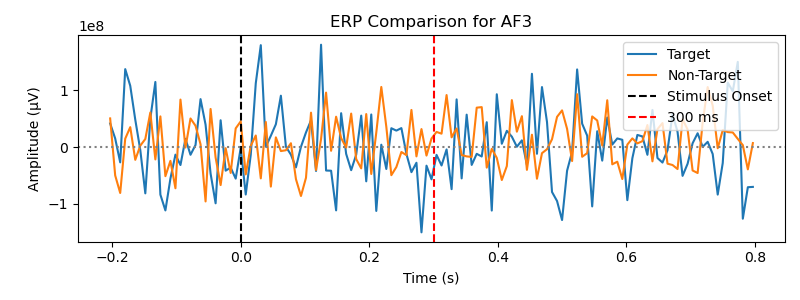

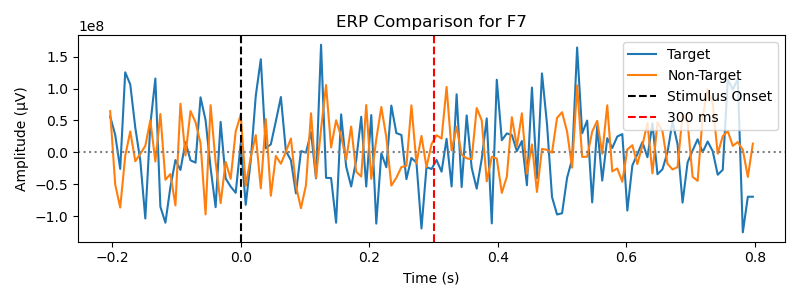

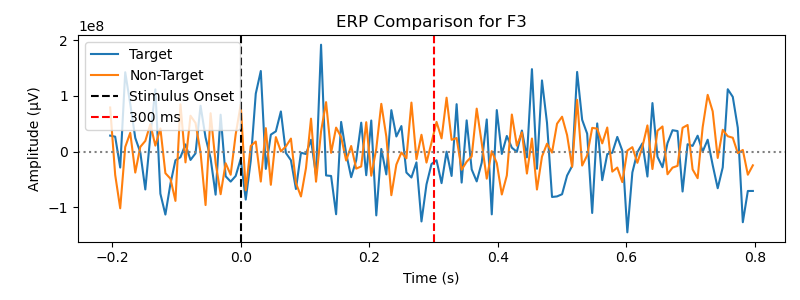

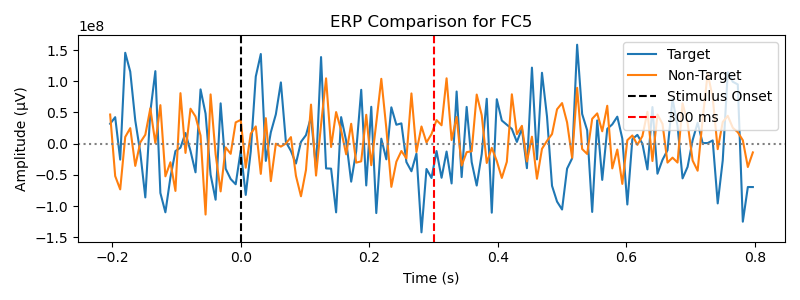

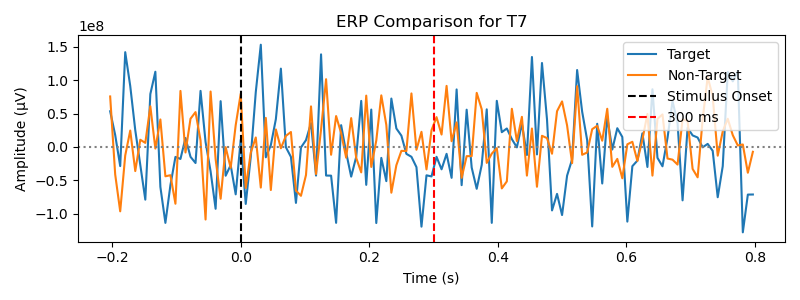

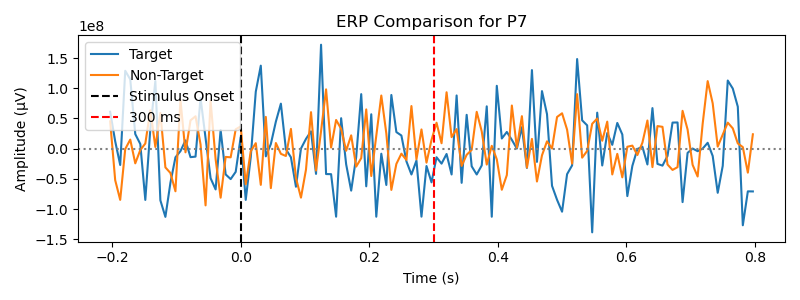

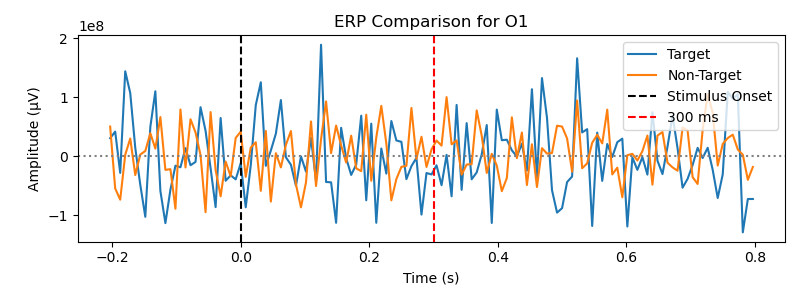

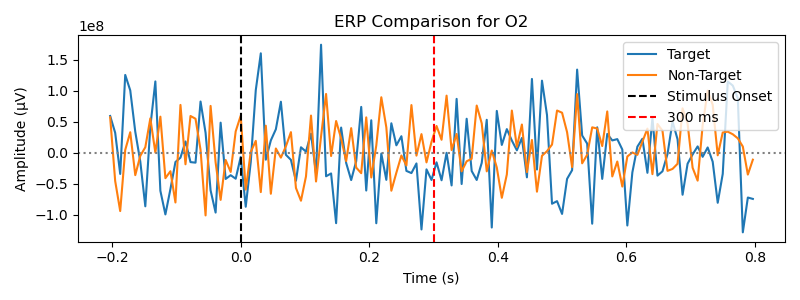

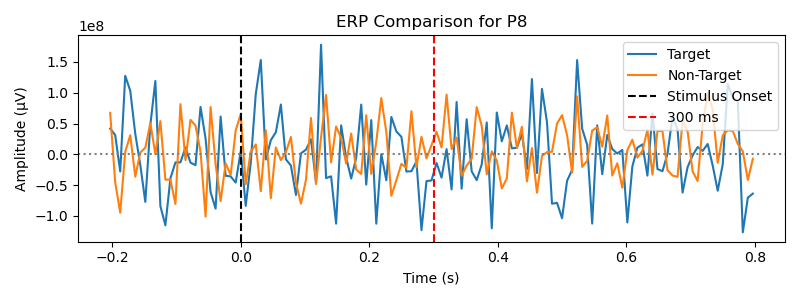

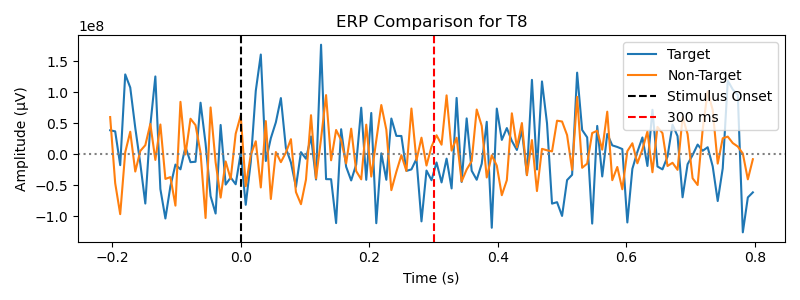

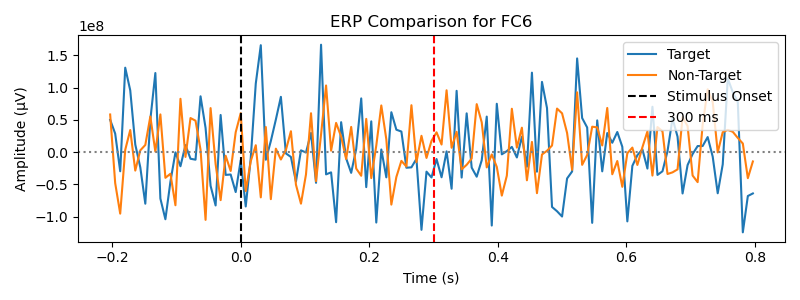

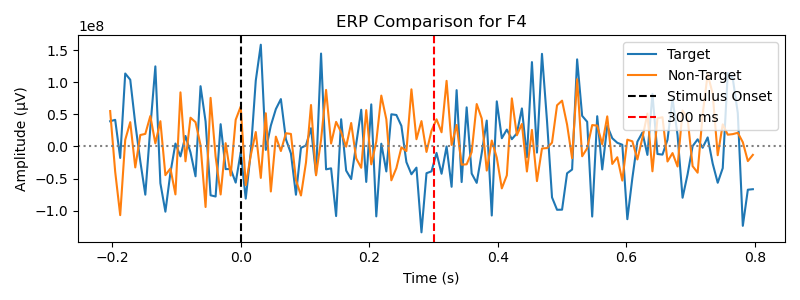

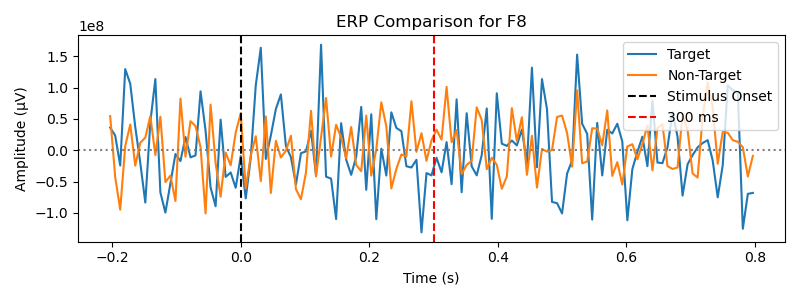

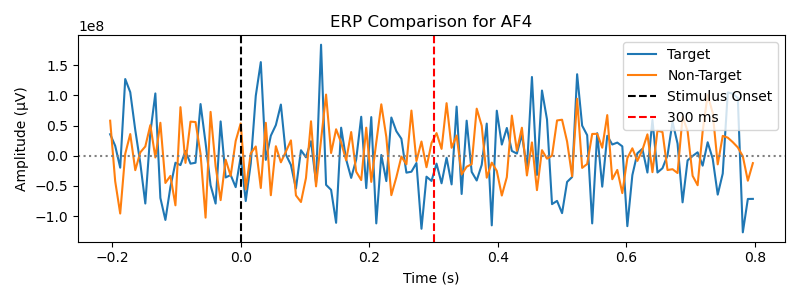

In [ ]:
import matplotlib.pyplot as plt
evoked_target = epochs['target'].average()
evoked_nontarget = epochs['nontarget'].average()

# Get data
times = evoked_target.times
data_target = evoked_target.data
data_nontarget = evoked_nontarget.data
ch_names = evoked_target.info['ch_names']

# Plot each channel
for i, ch in enumerate(ch_names):
    plt.figure(figsize=(8, 3))
    plt.plot(times, data_target[i] * 1e6, label='Target')       # µV
    plt.plot(times, data_nontarget[i] * 1e6, label='Non-Target') # µV
    plt.axvline(0.0, color='black', linestyle='--', label='Stimulus Onset')
    plt.axvline(0.3, color='red', linestyle='--', label='300 ms')
    plt.axhline(0, color='gray', linestyle=':')
    plt.title(f'ERP Comparison for {ch}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (µV)')
    plt.legend()
    plt.tight_layout()
    plt.show()


**Error: All channels look nearly the same...**